In [8]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import math
import pydotplus as dot
from IPython.display import SVG
import numpy as np

In [2]:
%reload_ext autoreload
%autoreload 2
from projet_madi import *

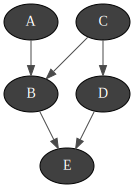

In [3]:
bn=gum.fastBN("A->B<-C->D->E<-B")
gnb.showBN(bn)

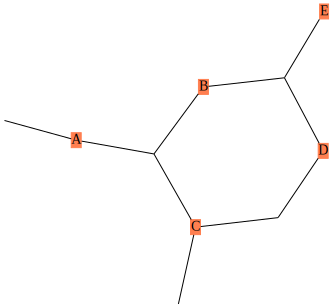

In [4]:
fg=FactorGraph()
fg.build(bn)
fg.show()

In [69]:
class Message:
    def __init__(self, sender, receiver, content=[]):
        self.sender = sender
        self.receiver = receiver
        self.content = content
        
    def send(self, letterboxes):
        letterboxes[self.receiver].append(self)

In [828]:
def inference(instance, function):
    # Initialisation
    letterboxes = instance.letterboxes.copy()
    root = np.random.randint(len(instance.fg.factors))
    leaves = instance.fg.leaves()
    if root in leaves:
        leaves.remove(root)
    paths = [instance.fg.shortest_path(leaf,root) for leaf in leaves]
    
    print(root)
    
    # ETAPE I
    var_step = False
    while len(paths) > 0:
        for path in paths:
            node = path.pop(0)
            if var_step and node != root:
                p = gum.Potential()
                for m in letterboxes[node]:
                    if m.sender != node:
                        p = p * m.content
                message = Message(node,path[0],p)
                message.send(letterboxes)
            elif not var_step and node != root:
                message = sumProduct(letterboxes,node,path[0],instance.fg.factors[node])
                message.send(letterboxes)

            if len(path) == 0:
                paths.remove(path)
        var_step = not var_step

    # ETAPE II
    to_visit = [root]
    visited = []

    var_step = False
    while len(to_visit) > 0:
        next_gen = []
        for node in to_visit:
            for neigh in [n for n in instance.fg.neighbours(node) if not n in visited]:
                visited.append(neigh)
                next_gen.append(neigh)
                if var_step:
                    p = gum.Potential()
                    for m in letterboxes[node]:
                        if m.sender != neigh:
                            p = p * m.content
                    message = Message(node,neigh,p)
                    message.send(letterboxes)
                else:
                    message = sumProduct(letterboxes,node,neigh,instance.fg.factors[node])
                    message.send(letterboxes)
        var_step = not var_step
        to_visit = next_gen

    return letterboxes

def sumProduct(letterboxes, sender, receiver, potential):
    p = gum.Potential(potential)
    for m in letterboxes[sender]:
        if m.sender != receiver:
            p = p * m.content
    content = p.margSumIn(receiver)

    return Message(sender, receiver, content=content)

class TreeSumProductInference:
    def __init__(self,f):
        self.fg = f
        self.letterboxes = {}
        for v in f.variables:
            self.letterboxes[v] = []
        for i in range(len(f.factors)):
            self.letterboxes[i] = []
    

    def makeInference(self):
        """ effectue les calculs de tous les messages """
        self.letterboxes = inference(self, sumProduct)

    def posterior(self, variable):
        """ retourne la distribution de la variable sous la forme d'un `gum.Potential` """
        try:
            messages_received = self.letterboxes[variable]
            for m in messages_received:
                if m.content[0] < 0.999 and m.content[0] > 0.001:
                    return m.content
        except KeyError:
            print("{} not found in variables, try to makeInference on the object.".format(variable))

In [839]:
spi=TreeSumProductInference(fg) # Crée une instance d'inférence
spi.makeInference() # effectue les calculs de tous les messages
spi.posterior("E")

0


In [630]:
ie = gum.LazyPropagation(bn)
ie.makeInference()
ie.posterior("D")

(gum::Potential<double>@0x55faf1f4c110) <D:0> :: 0.421151 /<D:1> :: 0.578849

In [156]:
"""

ETAPE 1 :
Choix d'un noeud racine
On trouve les feuilles (différents de la racine)
On trouve les chemins de chaque feuilles vers le noeud


Disons que l'on a n feuilles, donc n chemins. On parcours en parallèle ces n chemins en faisant itérativement
au moins n étapes "facteur" puis n étapes "variable".

Initialisation des boîtes au lettres :
- gum.Potential pour les b-o-l des variables
- [] pour les b-o-l des facteurs

etape_variable = 1
while (chemins non vides):
    pour tous les chemins :
        tete = chemin.pop()
        si etape_variable == 1:
            calcul du message : produit des messages en b-o-l
            envoi d'un message de type variable à son successeur dans le chemin
        sinon :
            calcul du message :  produit du facteur avec les messages de la bol puis 
                marginalisation sur la variable du voisin vers lequel on envoie
            envoi d'un message de type facteur à son successeur dans le chemin

    etape_variable = 1 - etape_variable
    
    
    
ETAPE 2:
to_visit = racine
visited = []

etape_variable = 1
while(to_visit no vide):
    pour tout noeud dans to_visit:
        pour tout voisin non visité :
            ajouter le voisin à la prochaine génération
            si etape_variable == 1:
                calcul message: produit des messages en b-o-l dont sender != voisin
                envoi du message au voisin
            sinon:
                calcul message: 
                envoi du message au voisin
    etape_variable = 1 - etape_variable
                    


    
Besoin d'une fonction qui retourne les voisins d'un noeud
Besoin d'une fonction qui retourne les chemins étant donné un noeud racine.

"""

'\n\nETAPE 1 :\nChoix d\'un noeud racine\nOn trouve les feuilles (différents de la racine)\nOn trouve les chemins de chaque feuilles vers le noeud\n\n\nDisons que l\'on a n feuilles, donc n chemins. On parcours en parallèle ces n chemins en faisant itérativement\nau moins n étapes "facteur" puis n étapes "variable".\n\nInitialisation des boîtes au lettres :\n- gum.Potential pour les b-o-l des variables\n- [] pour les b-o-l des facteurs\n\netape_variable = 1\nwhile (chemins non vides):\n    pour tous les chemins :\n        tete = chemin.pop()\n        si etape_variable == 1:\n            calcul du message : produit des messages en b-o-l\n            envoi d\'un message de type variable à son successeur dans le chemin\n        sinon :\n            calcul du message :  produit du facteur avec les messages de la bol puis \n                marginalisation sur la variable du voisin vers lequel on envoie\n            envoi d\'un message de type facteur à son successeur dans le chemin\n\n    e

In [ ]:
"""
def sumProduct(letterbox, sender, receiver, potential):
    p = Potential(potential)
    for m in letterbox:
        if m.sender != receiver:
            p = p * m.content
    content = p.margSumIn(receiver)
                    
    return Message(sender, receiver, content=content)

def maxProduct(letterbox, sender, receiver, potential):
    p = Potential(potential)
    for m in letterbox:
        p = p * m.content
    p = p.margMaxIn(receiver)
    best_index = p.argmax()[0][receiver]
    p[best_index] = 1
    p[1-best_index] = 0
    
    return Message(sender, receiver, content=content)
    
def maxSum(letterbox, sender, receiver, potential):
"""

In [290]:
spi=TreeSumProductInference(fg) # Crée une instance d'inférence
spi.makeInference() # effectue les calculs de tous les messages
spi.posterior("D")

(gum::Potential<double>@0x563e55c2e920) <D:0> :: 0.545678 /<D:1> :: 0.454322

In [251]:
mpi=TreeMaxProductInference(fg) #ou TreeMaxSumInference
mpi.makeInference()         # effectue les calculs de tous les messages
mpi.argmax()                # retourne un dictionnaire des valeurs des variables pour le MAP

{'A': 0, 'E': 0, 'D': 1, 'C': 1, 'B': 0}

In [296]:
ppp = bn.cpt(1) * pot
ppp

(gum::Potential<double>@0x563e55b3bf20) <B:0|A:0|C:0> :: 0.23221 /<B:1|A:0|C:0> :: 0.76779 /<B:0|A:1|C:0> :: 0.664676 /<B:1|A:1|C:0> :: 0.335324 /<B:0|A:0|C:1> :: 0.348192 /<B:1|A:0|C:1> :: 0.651808 /<B:0|A:1|C:1> :: 0.67429 /<B:1|A:1|C:1> :: 0.32571

In [297]:
bn.cpt(1)

(gum::Potential<double>@0x563e5564e020) <B:0|A:0|C:0> :: 0.23221 /<B:1|A:0|C:0> :: 0.76779 /<B:0|A:1|C:0> :: 0.664676 /<B:1|A:1|C:0> :: 0.335324 /<B:0|A:0|C:1> :: 0.348192 /<B:1|A:0|C:1> :: 0.651808 /<B:0|A:1|C:1> :: 0.67429 /<B:1|A:1|C:1> :: 0.32571

Proposer un code buildLDPC(bits,parity) qui, à partir d'une liste de bits (bits=['x1','x2','x3']) et d'un dictionnaire indiquant les contraintes de parité (parity={'pc1':['x1','x2'],'pc2':['x1','x2','x3']}), construit le réseau bayésien correspondant.
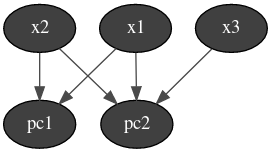

In [268]:
def buildLDPC(bits,parity):
    bn=gum.BayesNet('LDPC')
    for bit in bits:
        bn.add(gum.LabelizedVariable(bit,bit+'name',2))
    for pc, bits_ in parity.items():
        bn.add(gum.LabelizedVariable(pc,pc+'name',2))
        for bit in bits_:
            bn.addArc(bit,pc)
    return bn

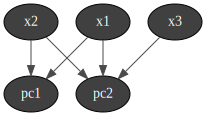

In [272]:
bn = buildLDPC(['x1','x2','x3'],{'pc1':['x1','x2'],'pc2':['x1','x2','x3']})
gnb.showBN(bn)

In [282]:
for i in bn.nodes():
    bn.cpt(i)
    print("cpt {} : {}".format(i,bn.cpt(i)))

cpt 0 : <x1:0> :: 0 /<x1:1> :: 0
cpt 1 : <x2:0> :: 0 /<x2:1> :: 0
cpt 2 : <x3:0> :: 0 /<x3:1> :: 0
cpt 3 : <pc1:0|x1:0|x2:0> :: 0 /<pc1:1|x1:0|x2:0> :: 0 /<pc1:0|x1:1|x2:0> :: 0 /<pc1:1|x1:1|x2:0> :: 0 /<pc1:0|x1:0|x2:1> :: 0 /<pc1:1|x1:0|x2:1> :: 0 /<pc1:0|x1:1|x2:1> :: 0 /<pc1:1|x1:1|x2:1> :: 0
cpt 4 : <pc2:0|x1:0|x2:0|x3:0> :: 0 /<pc2:1|x1:0|x2:0|x3:0> :: 0 /<pc2:0|x1:1|x2:0|x3:0> :: 0 /<pc2:1|x1:1|x2:0|x3:0> :: 0 /<pc2:0|x1:0|x2:1|x3:0> :: 0 /<pc2:1|x1:0|x2:1|x3:0> :: 0 /<pc2:0|x1:1|x2:1|x3:0> :: 0 /<pc2:1|x1:1|x2:1|x3:0> :: 0 /<pc2:0|x1:0|x2:0|x3:1> :: 0 /<pc2:1|x1:0|x2:0|x3:1> :: 0 /<pc2:0|x1:1|x2:0|x3:1> :: 0 /<pc2:1|x1:1|x2:0|x3:1> :: 0 /<pc2:0|x1:0|x2:1|x3:1> :: 0 /<pc2:1|x1:0|x2:1|x3:1> :: 0 /<pc2:0|x1:1|x2:1|x3:1> :: 0 /<pc2:1|x1:1|x2:1|x3:1> :: 0


In [275]:
message = {"x1":1,"x3":1,'pc2':0}